In [1]:
# --- Initialisation ---
import os
import sys
import pandas as pd
import numpy as np
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import recall_score, make_scorer, ConfusionMatrixDisplay


# --- Accès au dossier contenant utils.py ---
sys.path.append(os.path.abspath(".."))
from utils import execute_model_and_save_score, execute_model

# --- Chargement des données AU CHOIX ---
# DF_PATH = "../data/cardio_optimized.csv"
# DF_PATH = "../data/cardio_light.csv"
DF_PATH = "../data/cardio_prepro_light_std.csv"

df = pd.read_csv(DF_PATH, sep=";")

# --- Séparation des features et de la cible ---
X = df.drop(columns=["cardio"])
y = df["cardio"]


# 1. Créer un scorer personnalisé pour le recall de la classe 1
recall_scorer = make_scorer(
    recall_score, 
    pos_label=1  # Spécifie que la classe 1 est la classe positive
)

model = LogisticRegression()


#### `LogisticRegression` avec `GridSearchCV`
Recherche et stockage des meilleurs hyperparamètres dans `best_model_grid`

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

param_grid = {
    'C': [50, 100, 150, 200],
    'penalty': ['l2', 'l1', 'elasticnet'],  # ou 'l1' si le solver le permet
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [1000]
}

grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5, 
    scoring=recall_scorer
)

# Ne refais pas le fit si déjà fait
if "best_model_grid" not in globals():
    grid_search.fit(X_train, y_train)
    best_model_grid = grid_search.best_estimator_
    print("✅ Grid search terminée.")
else:
    print("✅ Modèle déjà entraîné : utilisation de best_model.")

# Sauvegarde
joblib.dump(best_model_grid, "best_model_logreg.joblib")

print("Meilleurs estimateurs trouvés :", grid_search.best_estimator_)
print("Meilleurs hyperparamètres trouvés :", grid_search.best_params_)
print("Meilleur score d'entraînement :", grid_search.best_score_)



✅ Modèle déjà entraîné : utilisation de best_model.


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

#### `LogisticRegression` avec `RandomizedSearchCV`
Recherche et stockage des meilleurs hyperparamètres dans `best_model_radom`

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

param_distributions = {
    'C':  [150, 200], # C variera de 0.01 à 100, selon une distribution log-uniforme
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [500]
}

randomized_search = RandomizedSearchCV(
    estimator = model,
    param_distributions=param_distributions,  # ou param_grid si tu préfères, mais param_distributions est la convention
    cv=5,
    scoring=recall_scorer,  # Optimise spécifiquement le recall de la classe 1
    n_iter=5,  # Ici, 2 car tu n'as que 2 valeurs pour C, mais à adapter selon ton espace de paramètres
    random_state=42
                           )

# 2. Lancer l'entraînement avec .fit(), Ne relance pas le fit si déjà effectué
if "best_model_random" not in globals():
    randomized_search.fit(X_train, y_train)
    best_model_random = randomized_search.best_estimator_
    print("✅ Randomized search terminée.")
else:
    print("✅ Modèle aléatoire déjà entraîné : utilisation de best_model_random.")

# Sauvegarde sur disque
joblib.dump(best_model_random, "best_model_random_logreg.joblib")


print("Meilleurs hyperparamètres trouvés :", randomized_search.best_params_ if "randomized_search" in globals() else best_model_random.get_params())
print("Meilleur score d'entraînement (recall classe 1) :", randomized_search.best_score_ if "randomized_search" in globals() else "déjà calculé")

c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO.

✅ Randomized search terminée.
Meilleurs hyperparamètres trouvés : {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 500, 'C': 150}
Meilleur score d'entraînement (recall classe 1) : 0.6844220333676283


## Execution du modele

In [2]:
# Chargement des meilleurs paramètre de GridSearchCV 
best_model_grid = joblib.load("best_model_logreg.joblib")
# et RandomSearchCV
best_model_random_grid = joblib.load("best_model_random_logreg.joblib")

In [3]:

# ============== EXECUTION de modèles et ENREGISTREMENT des métriques ================

# execute_model_and_save_score(X, y)
# execute_model_and_save_score(X, y, max_iter=1000, penalty="l2", solver="lbfgs")
# execute_model_and_save_score(X, y, max_iter=2000, penalty="l2", solver="lbfgs")
# execute_model_and_save_score(X, y, max_iter=2000, solver="lbfgs")
# execute_model_and_save_score(X, y, df_path=DF_PATH, max_iter=2000)
# execute_model_and_save_score(X, y, df_path=DF_PATH, penalty="l2", solver="lbfgs", max_iter=2000)
# execute_model_and_save_score(X, y, df_path=DF_PATH, penalty='l1', solver='liblinear')
# execute_model_and_save_score(X, y, df_path=DF_PATH, penalty='l1', solver='saga')
# execute_model_and_save_score(X, y, df_path=DF_PATH, penalty='l2', solver='newton-cg')
# execute_model_and_save_score(X, y, max_iter=2000, df_path=DF_PATH, penalty='l2', solver='newton-cg')
# execute_model_and_save_score(X, y, C= 100, max_iter=1000, penalty= 'l2', solver= 'liblinear', df_path = DF_PATH)
# execute_model_and_save_score(X, y, C= 200, max_iter= 1000, penalty= 'l2', solver= 'liblinear', df_path = DF_PATH)
# execute_model_and_save_score(X, y, C= 200, max_iter= 1000, penalty= 'l2', solver= 'liblinear', df_path = DF_PATH)
# execute_model_and_save_score(X, y, C= 150, max_iter= 1000, penalty= 'l2', solver= 'liblinear', df_path = DF_PATH)
# execute_model_and_save_score(X, y, C= 200, max_iter= 1000, penalty= 'l2', solver= 'liblinear', df_path = DF_PATH)
execute_model_and_save_score(X, y, model=best_model_grid)

✅ Accuracy : 0.716
📊 Rapport de classification :
               precision    recall  f1-score   support

           0       0.71      0.75      0.73      6926
           1       0.73      0.68      0.70      6787

    accuracy                           0.72     13713
   macro avg       0.72      0.72      0.72     13713
weighted avg       0.72      0.72      0.72     13713

🧱 Matrice de confusion :
 [[5208 1718]
 [2176 4611]]
Résultat enregistré dans ../results.csv


In [ ]:
y_test, y_pred, y_proba, X_test = execute_model(X, y, model=best_model_grid)

✅ Accuracy : 0.716
📊 Rapport de classification :
               precision    recall  f1-score   support

           0       0.71      0.75      0.73      6926
           1       0.73      0.68      0.70      6787

    accuracy                           0.72     13713
   macro avg       0.72      0.72      0.72     13713
weighted avg       0.72      0.72      0.72     13713
 

🧱 Matrice de confusion :
 [[5208 1718]
 [2176 4611]] 

Precision :  0.7169
Recall :  0.7157
Recall 1 :  0.6794
F 1 :  0.7155


In [4]:
print(np.unique(y_pred, return_counts=True))

(array([0, 1]), array([7323, 6390]))


## Modification du seuil

In [ ]:
# Obtenir les probabilités pour la classe 1
y_proba = best_model_grid_search.predict_proba(X_test)[:, 1]

# Trouver le seuil qui maximise le recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

In [6]:
print(precision, recall, thresholds)

[0.49493182 0.49496791 0.49500401 ... 1.         1.         1.        ] [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 2.94681008e-04
 1.47340504e-04 0.00000000e+00] [0.04941774 0.05046202 0.05180593 ... 0.94176566 0.94270709 0.94402728]


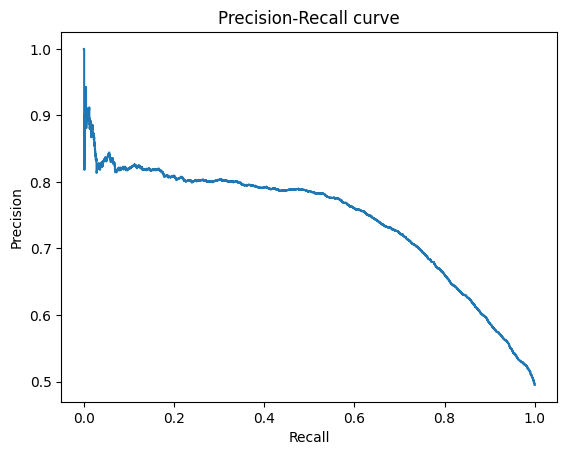

In [7]:
import matplotlib.pyplot as plt

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()


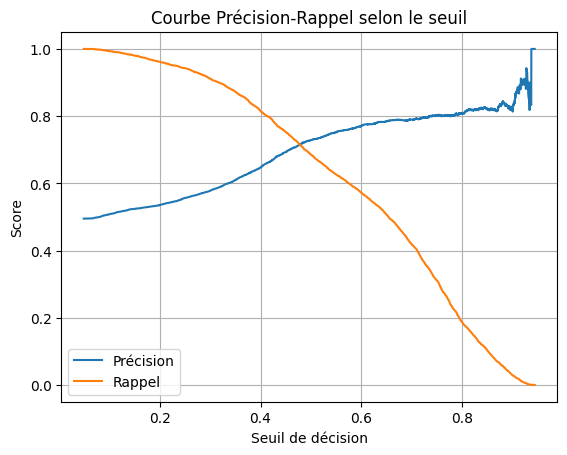

In [8]:
plt.plot(thresholds, precision[:-1], label='Précision')
plt.plot(thresholds, recall[:-1], label='Rappel')
plt.xlabel('Seuil de décision')
plt.ylabel('Score')
plt.legend()
plt.title('Courbe Précision-Rappel selon le seuil')
plt.grid()
plt.show()


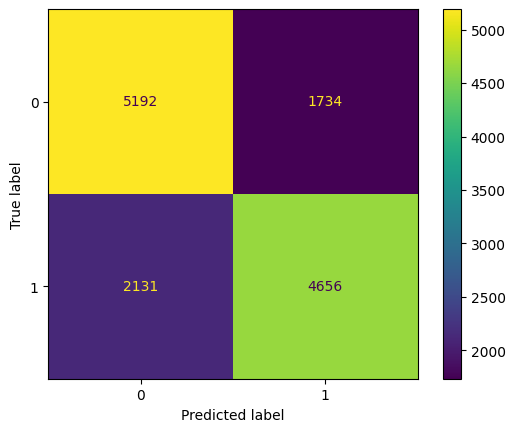

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


In [13]:
# Exemple : choisir un seuil qui donne un recall élevé (ici, le premier seuil où recall > 0.9)
target_recall = 0.2
# On compare recall[:-1] car thresholds a une valeur de moins que recall
mask = recall[:-1] > target_recall

if mask.any():  # S'il existe un seuil qui donne recall > 0.9
    threshold = thresholds[mask][0]
else:
    print("Aucun seuil ne permet d'atteindre recall >", target_recall)
    threshold = thresholds[-1]  # On prend le dernier seuil disponible

# Prédire avec le nouveau seuil
y_pred = (y_proba >= threshold).astype(int)

# Évaluer les performances
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6926
           1       0.49      1.00      0.66      6787

    accuracy                           0.49     13713
   macro avg       0.25      0.50      0.33     13713
weighted avg       0.24      0.49      0.33     13713



c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\coule\Documents\projets\cardio-vasc-risks\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera